In [1]:
from warnings import filterwarnings
filterwarnings("ignore")
import pandas as pd
from typing import List, Union, Literal, Dict
import numpy as np
from tqdm import tqdm
from crypto_momentum_portfolios.utility.data_loader import CryptoDataLoader, CryptoDataLoaderQIL
from crypto_momentum_portfolios.utility.utils import get_rebalance_dates
from crypto_momentum_portfolios.utility.types import (
    DataFrequency,
    Fields,
    RebalanceFrequency,
    Side,
)
dl = CryptoDataLoaderQIL()  # CryptoDataLoader()

dl.assets

Fetching symbols...: 100%|██████████| 17/17 [00:00<00:00, 34.79it/s]


['BNB-USDT',
 'BCH-USDT',
 'ETC-USDT',
 'XLM-USDT',
 'TRX-USDT',
 'ADA-USDT',
 'XRP-USDT',
 'ETH-USDT',
 'SOL-USDT',
 'DASH-USDT',
 'DOGE-USDT',
 'XTZ-USDT',
 'LTC-USDT',
 'LINK-USDT',
 'BTC-USDT',
 'MATIC-USDT',
 'AVAX-USDT']

In [12]:
MOMENTUM_LOOKBACK = 30
universe = (
    dl.get_crypto(
        "all",
        data_frequency=DataFrequency.DAILY,
        fields=[Fields.PRICE, Fields.MARKET_CAP, Fields.MOMENTUM, Fields.RETURNS],
        flatten_fields_with_crypto=False,
        momentum_lookback=MOMENTUM_LOOKBACK,
    )
    .dropna()
    .loc[:]
)
universe.head()

price                                                           \
           BNB-USDT BCH-USDT ETC-USDT  XLM-USDT  TRX-USDT  ADA-USDT XRP-USDT   
Date                                                                           
2021-09-02  483.465   664.49  67.6071  0.359000  0.099526  2.960618  1.25337   
2021-09-03  488.472   713.32  69.9936  0.368773  0.101654  2.965665  1.29075   
2021-09-04  497.691   708.80  68.7689  0.369760  0.101457  2.828828  1.25500   
2021-09-05  504.940   765.00  73.5208  0.397779  0.105212  2.911501  1.30769   
2021-09-06  495.886   784.61  73.4993  0.423930  0.103767  2.830175  1.38957   

                                        ...   returns                      \
           ETH-USDT SOL-USDT DASH-USDT  ...  ETH-USDT  SOL-USDT DASH-USDT   
Date                                    ...                                 
2021-09-02  3785.73  128.230    239.03  ... -0.011047  0.157478  0.000335   
2021-09-03  3940.10  146.287    247.46  ...  0.040777  0.140817  0.035268   
2021-09-04  3886.90  138.976    251.55  ... -0.013502 -0.049977  0.016528   
2021-09-05  3949.88  142.059    264.30  ...  0.016203  0.022184  0.050686   
2021-09-06  3926.36  164.276    255.46  ... -0.005955  0.156393 -0.033447   

                                                                         \
           DOGE-USDT  XTZ-USDT  LTC-USDT LINK-USDT  BTC-USDT MATIC-USDT   
Date                                                                      
2021-09-02  0.000068 -0.024023  0.013217  0.006309  0.008882  -0.014658   
2021-09-03  0.005501  0.003687  0.161611  0.027404  0.015474   0.007334   
2021-09-04  0.010671  0.016870 -0.004901 -0.028445 -0.002168   0.193351   
2021-09-05  0.050388  0.030189  0.096317  0.121998  0.037381  -0.032865   
2021-09-06 -0.016891  0.005382 -0.055738  0.038531  0.017370  -0.021901   

                      
           AVAX-USDT  
Date                  
2021-09-02  0.120434  
2021-09-03 -0.036382  
2021-09-04  0.026906  
2021-09-05  0.022064  
2021-09-06 -0.022128  

[5 rows x 68 columns]

Weight drift :

$$w_i^k=\frac{w_{i-1}^k\times (1+r_i^k)}{\sum_{j=1}^n w_{i-1}^j\times(1+r_i^j)}$$

For asset $k$ at time $i$ given $n$ asset in the portfolio.


# Building a benchmark


## Capitalization weighted index


In [14]:
from crypto_momentum_portfolios.portfolio_management.benchmarks import BenchmarkDataFrameBuilder

benchmarks = (
    BenchmarkDataFrameBuilder(universe)
    .build_equally_weighted_benchmark(
        rebalance_frequency=RebalanceFrequency.MONTHLY, side=Side.LONG, verbose=False
    )
    .build_capitalization_weighted_benchmark(
        capitalization_field=Fields.MARKET_CAP,
        rebalance_frequency=RebalanceFrequency.MONTHLY,
        side=Side.LONG,
        verbose=False,
    )
    .build_bitcoin_benchmark()
    .collect_benchmark_returns()
)

benchmarks

Building the Benchmark...:   0%|          | 0/844 [00:00<?, ?it/s]

,equal_weighted_benchmark,capi_weighted_benchmark,bitcoin_benchmark
Date,,,
2021-09-02,0.003035,-0.002418,0.008882
2021-09-03,0.035882,0.027487,0.015474
2021-09-04,0.003692,-0.014289,-0.002168
2021-09-05,0.044229,0.032174,0.037381
2021-09-06,0.010233,0.012805,0.017370
...,...,...,...
2023-12-20,0.032672,0.037325,0.033060
2023-12-21,0.044564,0.030241,0.004402
2023-12-22,0.001661,0.001747,-0.007230


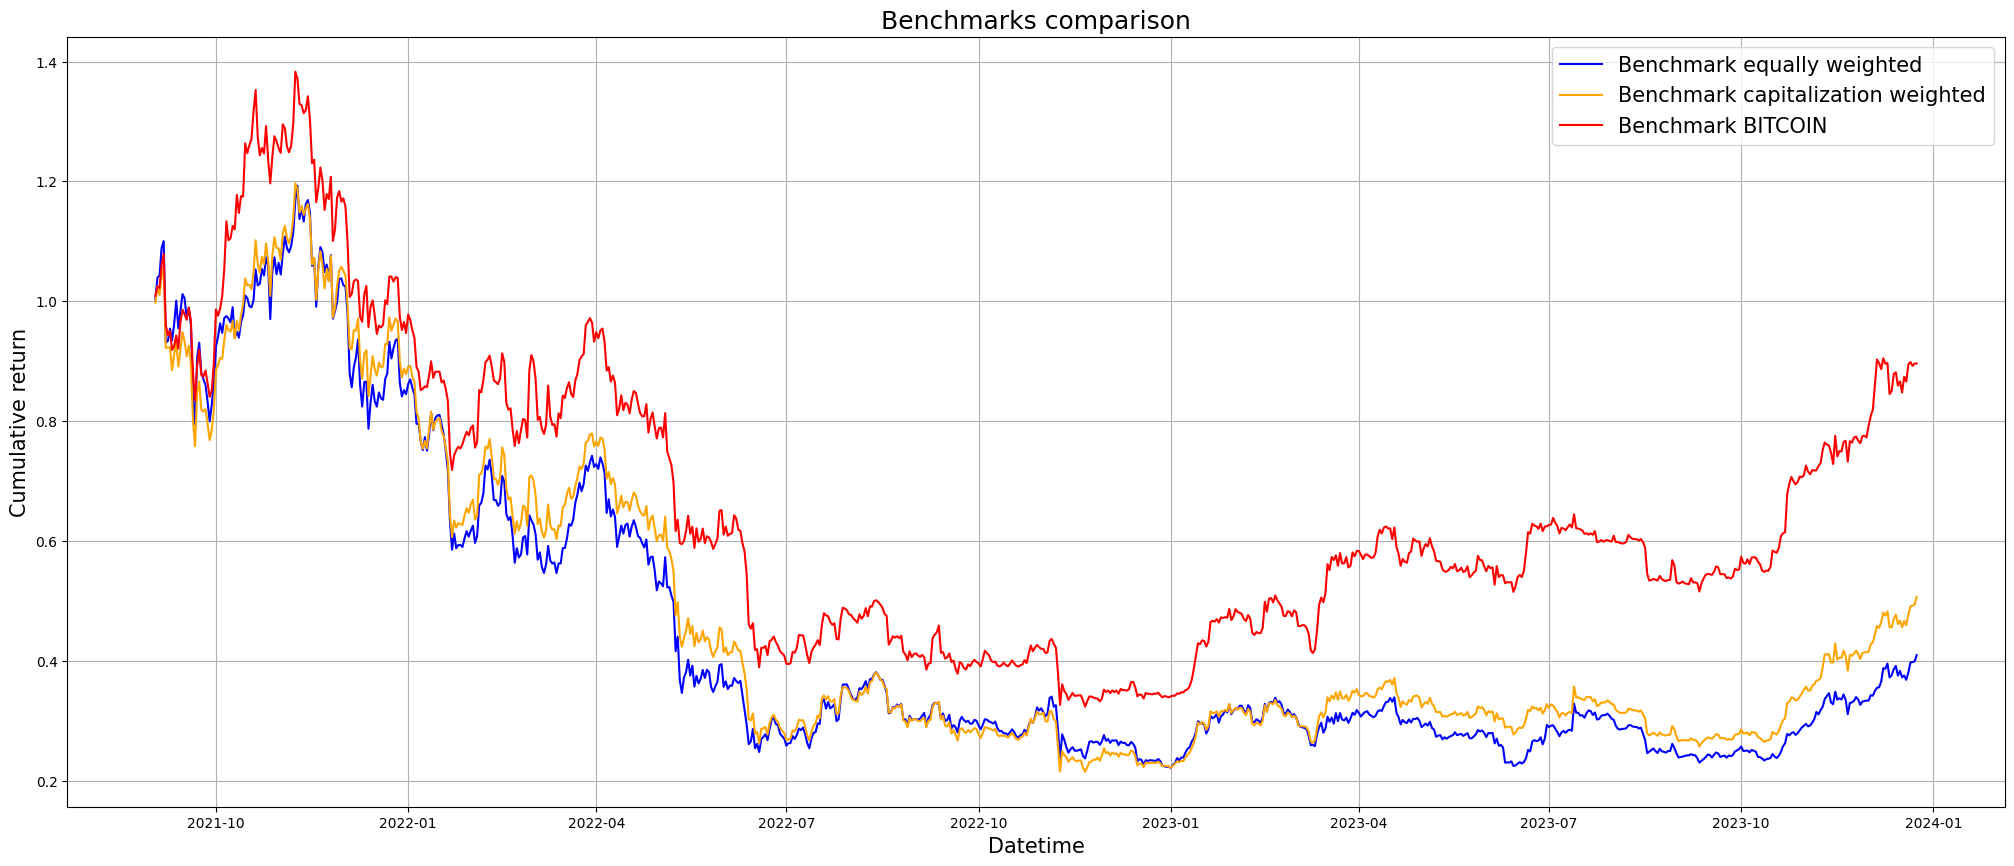

In [15]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(25, 10))
ax.set_title("Benchmarks comparison", fontsize=18)
ax.grid()
ax.plot(
    (benchmarks["equal_weighted_benchmark"] + 1).cumprod(),
    label="Benchmark equally weighted",
    color="blue",
)
ax.plot(
    (benchmarks["capi_weighted_benchmark"] + 1).cumprod(),
    label="Benchmark capitalization weighted",
    color="orange",
)
ax.plot(
    (benchmarks["bitcoin_benchmark"] + 1).cumprod(),
    label="Benchmark BITCOIN",
    color="red",
)


ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Cumulative return", fontsize=15)
ax.legend(loc="upper right", fontsize=15)
# ax.set_yscale("log")

# Backtesting strategies


In [ ]:
from crypto_momentum_portfolios.portfolio_management.allocation import equal_weighted_allocation
from crypto_momentum_portfolios.portfolio_management.selection import rank_by_field_for_rows
from crypto_momentum_portfolios.utility.constants import SLIPPAGE_EFFECT, TRANSACTION_COST


returns_histo, weights_histo = [], []
REBALANCE_DATES = get_rebalance_dates(
    universe.index[0], universe.index[-1], RebalanceFrequency.MONTHLY
)

TOP_K = 3
SIDE: Side = Side.LONG

for index, row in tqdm(
    universe.iterrows(),
    desc="Backtesting the strategy...",
    total=len(universe),
    leave=False,
):
    if index in REBALANCE_DATES or index == universe.index[0]:
        print(f"Rebalancing the portfolio on {index}...")
        securities = rank_by_field_for_rows(row, "momentum")[-TOP_K:]
        weights = equal_weighted_allocation(securities)

    weights_histo.append(weights)
    returns = universe.loc[index, "returns"][securities].to_numpy()

    weights_np = np.array(list(weights.values()))
    if index in REBALANCE_DATES or index == universe.index[0]:
        returns_histo.append(
            ((returns @ weights_np) - TRANSACTION_COST * TOP_K - SLIPPAGE_EFFECT)
            * SIDE
        )
    else:
        returns_histo.append((returns @ weights_np) * SIDE)
    new_weights = {
        sec: unit_weight
        for sec, unit_weight in zip(
            securities,
            (weights_np * (returns + 1)) / ((returns + 1) @ weights_np),
        )
    }
    weights = new_weights

In [ ]:
weights_df = pd.DataFrame(weights_histo, index=universe.index).fillna(0)
returns_df = pd.DataFrame(
    returns_histo, columns=["Startegy_returns"], index=universe.index, dtype=float
)
returns_df["Startegy_cumulative_returns"] = (
    1 + returns_df["Startegy_returns"]
).cumprod()
returns_df["Bench_returns"] = universe["returns"]["bitcoin"]
returns_df["Bench_cumulative_returns"] = (1 + returns_df["Bench_returns"]).cumprod()

In [ ]:
returns_df

## Result analysis


In [ ]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(25, 10))
ax.set_title(
    "Backtest track of the 24 days momentum strategy with montly rebalance", fontsize=18
)
ax.plot(
    returns_df["Startegy_cumulative_returns"],
    label="Stretegy",
    color="blue",
)

ax.plot(returns_df["Bench_cumulative_returns"], label="Benchmark", color="orange")
ax.set_xlabel("Datetime", fontsize=15)
ax.set_ylabel("Cumulative return", fontsize=15)
ax.legend(loc="upper left")
ax.set_yscale("log")

ax.grid()

In [ ]:
from quant_invest_lab.reports import (
    print_portfolio_strategy_report,
    plot_from_trade_df_and_ptf_optimization,
)

print_portfolio_strategy_report(
    portfolio_returns=pd.Series(returns_histo, index=universe.index),
    benchmark_returns=universe["returns"]["bitcoin"],
    timeframe="1day",
)

In [ ]:
alloc = pd.DataFrame(weights_df.mean())
alloc.columns = [0]
alloc = alloc.T


plot_from_trade_df_and_ptf_optimization(
    portfolio_returns=returns_df["Startegy_returns"],
    benchmark_returns=returns_df["Bench_returns"],
    asset_allocation_dataframe=alloc,
)

## Weights analysis


In [ ]:
weights_df